# Neural Network

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

import matplotlib.pyplot as plt

In [0]:
def build_model(num_features, num_classes):
  model = Sequential()
  model.add(Dense(num_features, input_dim=num_features, activation='tanh'))
  model.add(Dense(64, activation='tanh'))
  model.add(Dense(32, activation='tanh'))
  model.add(Dense(num_classes, activation='softmax'))

  model.summary()
  
  model.compile(
      optimizer='nadam',
      loss=tf.keras.losses.categorical_crossentropy,
      metrics=['accuracy']
  )

  return model

In [0]:
def plot_train_val(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

# FE1

In [0]:
base_train = pd.read_feather('/content/drive/My Drive/introml/fe/fe1/fe1_train.feather')
base_test = pd.read_feather('/content/drive/My Drive/introml/fe/fe1/fe1_test.feather')

In [0]:
base_train = base_train.drop(['index'], axis=1)
base_train.head()

,installation_id,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_3010,event_code_3020,event_code_3021,event_code_3110,event_code_3120,event_code_3121,event_code_4020,event_code_4025,event_code_4030,event_code_4035,event_code_4040,event_code_4070,event_code_4080,event_code_4090,event_code_4100,event_code_4110,accuracy_group_x,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment),type_Assessment,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,"('game_time', 'sum')","('game_time', 'mean')","('game_time', 'std')",accuracy_group
0,0006a69f,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,3
1,0006a69f,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,0
2,0006a69f,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,3
3,0006a69f,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,2
4,0006a69f,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,3


In [0]:
#encode the installation_id
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(base_train['installation_id'])

base_train['installation_id'] = le.transform(base_train['installation_id'])

In [0]:
base_train.fillna(0, inplace=True)
base_train.head()

,installation_id,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_3010,event_code_3020,event_code_3021,event_code_3110,event_code_3120,event_code_3121,event_code_4020,event_code_4025,event_code_4030,event_code_4035,event_code_4040,event_code_4070,event_code_4080,event_code_4090,event_code_4100,event_code_4110,accuracy_group_x,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment),type_Assessment,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,"('game_time', 'sum')","('game_time', 'mean')","('game_time', 'std')",accuracy_group
0,0,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,3
1,0,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,0
2,0,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,3
3,0,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,2
4,0,5.0,4.0,6.0,3.0,5.0,3.0,16.0,12.0,13.0,16.0,12.0,13.0,18.0,34.0,46.0,0.0,3.0,18.0,0.0,0.0,5.0,12.0,11,2,0,0,0,3,5,0,0,5,227640,45528.0,26871.152245,3


In [0]:
base_test.fillna(0, inplace=True)
base_test.head()

,installation_id,event_code_2000,event_code_2010,event_code_2020,event_code_2025,event_code_2030,event_code_2035,event_code_2040,event_code_2050,event_code_2060,event_code_2070,event_code_2075,event_code_2080,event_code_2081,event_code_2083,event_code_3010,event_code_3020,event_code_3021,event_code_3110,event_code_3120,event_code_3121,event_code_4010,event_code_4020,event_code_4021,event_code_4022,event_code_4025,event_code_4030,event_code_4031,event_code_4035,event_code_4040,event_code_4045,event_code_4050,event_code_4070,event_code_4080,event_code_4090,event_code_4095,event_code_4100,event_code_4110,event_code_4220,event_code_4230,...,title_Crystal Caves - Level 2,title_Crystal Caves - Level 3,title_Crystals Rule,title_Dino Dive,title_Dino Drink,title_Egg Dropper (Activity),title_Fireworks (Activity),title_Flower Waterer (Activity),title_Happy Camel,"title_Heavy, Heavier, Heaviest",title_Honey Cake,title_Leaf Leader,title_Lifting Heavy Things,title_Magma Peak - Level 1,title_Magma Peak - Level 2,title_Mushroom Sorter (Assessment),title_Ordering Spheres,title_Pan Balance,title_Pirate's Tale,title_Rulers,title_Sandcastle Builder (Activity),title_Scrub-A-Dub,title_Slop Problem,title_Treasure Map,title_Tree Top City - Level 1,title_Tree Top City - Level 2,title_Tree Top City - Level 3,title_Watering Hole (Activity),title_Welcome to Lost Lagoon!,type_Activity,type_Assessment,type_Clip,type_Game,world_CRYSTALCAVES,world_MAGMAPEAK,world_NONE,world_TREETOPCITY,"('game_time', 'sum')","('game_time', 'mean')","('game_time', 'std')"
0,00abaee7,26.0,1.0,11.0,1.0,7.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,111.0,33.0,9.0,108.0,33.0,9.0,3.0,120.0,12.0,0.0,10.0,148.0,0.0,33.0,0.0,0.0,0.0,190.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,2.0,14.0,3.0,10.0,5.0,1.0,10.0,2723866,104764.076923,381874.875578
1,01242218,58.0,4.0,85.0,2.0,80.0,2.0,6.0,6.0,4.0,1.0,3.0,10.0,2.0,7.0,418.0,25.0,72.0,416.0,25.0,72.0,12.0,325.0,26.0,36.0,94.0,407.0,11.0,49.0,25.0,6.0,0.0,385.0,0.0,2.0,0.0,23.0,3.0,9.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0,11.0,6.0,29.0,12.0,22.0,14.0,2.0,20.0,3281050,56569.827586,77980.940399
2,017c5718,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,24.0,0.0,0.0,0.0,15.0,0.0,20.0,4.0,40.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,2.0,1.0,6.0,0.0,0.0,0.0,4.0,5.0,112850,12538.888889,24983.425223
3,01a44906,14.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,2.0,3.0,21.0,2.0,3.0,1.0,31.0,0.0,29.0,9.0,61.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,10.0,1.0,0.0,0.0,3.0,11.0,188268,13447.714286,29678.814242
4,01bc6cb6,25.0,0.0,28.0,9.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,75.0,27.0,27.0,73.0,27.0,27.0,6.0,146.0,0.0,3.0,0.0,231.0,0.0,62.0,16.0,4.0,0.0,134.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,17.0,6.0,12.0,3.0,3.0,7.0,1206578,48263.120000,113848.826745


In [0]:
x_all = base_train.drop(columns='accuracy_group')
y_all = base_train['accuracy_group']

x_train, x_test,y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

In [0]:
num_features = x_test.shape[1]
num_classes = len(set(y_test))
print(num_features, "features")
print(num_classes, "classes")

36 features
4 classes


In [0]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_test_cat

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [0]:
model1 = build_model(num_features, num_classes)
checkpoints = ModelCheckpoint("/content/drive/My Drive/introml/model/nn/checkpoints/fe1-weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                1332      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 5,912
Trainable params: 5,912
Non-trainable params: 0
_________________________________________________________________


In [0]:
history1 = model1.fit(np.array(x_train), np.array(y_train_cat), validation_split=0.25, epochs=100, batch_size=32, callbacks=[checkpoints])
# model.evaluate(x_val, y_val)

Train on 10614 samples, validate on 3538 samples
Epoch 1/100
10614/10614 [==============================] - 3s 249us/sample - loss: 1.2282 - accuracy: 0.4945 - val_loss: 1.2070 - val_accuracy: 0.5110
Epoch 2/100
10614/10614 [==============================] - 2s 180us/sample - loss: 1.2251 - accuracy: 0.4971 - val_loss: 1.2048 - val_accuracy: 0.5136
Epoch 3/100
10614/10614 [==============================] - 1s 137us/sample - loss: 1.2228 - accuracy: 0.4984 - val_loss: 1.2087 - val_accuracy: 0.5130
Epoch 4/100
10614/10614 [==============================] - 1s 137us/sample - loss: 1.2230 - accuracy: 0.4974 - val_loss: 1.2048 - val_accuracy: 0.5133
Epoch 5/100
10614/10614 [==============================] - 1s 137us/sample - loss: 1.2217 - accuracy: 0.4988 - val_loss: 1.2077 - val_accuracy: 0.5133
Epoch 6/100
10614/10614 [==============================] - 1s 135us/sample - loss: 1.2215 - accuracy: 0.4989 - val_loss: 1.2068 - val_accuracy: 0.5138
Epoch 7/100
10614/10614 [====================

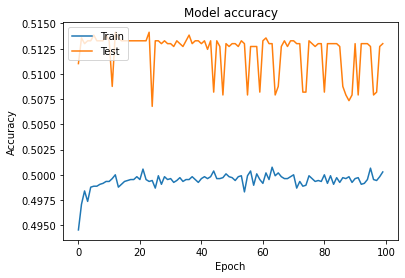

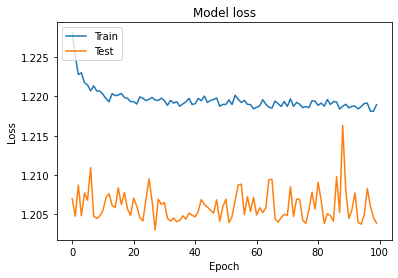

In [0]:
plot_train_val(history1)

In [0]:
y_pred = [np.argmax(y) for y in model1.predict(x_test)]
print(y_pred, y_test)
print(classification_report(y_test, y_pred))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# y_pred = [np.where(y == 1)[0][0] for y in y_pred]
print('cohen kappa score:', cohen_kappa_score(y_test, y_pred))

cohen kappa score: 0.002436755211913666


# FE2

In [0]:
base_train = pd.read_feather('/content/drive/My Drive/introml/fe/fe2/fe2_train.feather')
base_test = pd.read_feather('/content/drive/My Drive/introml/fe/fe2/fe2_test.feather')

In [0]:
#encode the installation_id
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(base_train['installation_id'])
base_train['installation_id'] = le.transform(base_train['installation_id']).astype(int)

In [0]:
base_train = base_train.fillna(0)
base_train['Cauldron Filler (Assessment)_4020_accuracy'] = np.log(base_train['Cauldron Filler (Assessment)_4020_accuracy'])
base_train['Mushroom Sorter (Assessment)_4020_accuracy'] = np.log(base_train['Mushroom Sorter (Assessment)_4020_accuracy'])
base_train['Bird Measurer (Assessment)_4020_accuracy'] = np.log(base_train['Bird Measurer (Assessment)_4020_accuracy'])
base_train['Chest Sorter (Assessment)_4020_accuracy'] = np.log(base_train['Chest Sorter (Assessment)_4020_accuracy'])



# base_train = base_train.drop(['Cauldron Filler (Assessment)_4020_accuracy', 'Mushroom Sorter (Assessment)_4020_accuracy',
#                               'Bird Measurer (Assessment)_4020_accuracy', 'Chest Sorter (Assessment)_4020_accuracy'],axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
x_all = base_train.drop(columns='accuracy_group')
y_all = base_train['accuracy_group']

x_train, x_test,y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

In [0]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [0]:
num_features = x_test.shape[1]
num_classes = len(set(y_test))
print(num_features, "features")
print(num_classes, "classes")

107 features
4 classes


In [0]:
model2 = build_model(num_features, num_classes)
checkpoints = ModelCheckpoint("/content/drive/My Drive/introml/model/nn/checkpoints/fe2-weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 107)               11556     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6912      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
Total params: 20,680
Trainable params: 20,680
Non-trainable params: 0
_________________________________________________________________


In [0]:
history2 = model2.fit(np.array(x_train), np.array(y_train_cat), validation_split=0.25, epochs=100, batch_size=32, callbacks=[checkpoints])


Train on 10614 samples, validate on 3538 samples
Epoch 1/100
10614/10614 [==============================] - 2s 227us/sample - loss: 1.2435 - accuracy: 0.4891 - val_loss: 1.2126 - val_accuracy: 0.5096
Epoch 2/100
10614/10614 [==============================] - 2s 170us/sample - loss: 1.2155 - accuracy: 0.5029 - val_loss: 1.2093 - val_accuracy: 0.5119
Epoch 3/100
10614/10614 [==============================] - 2s 168us/sample - loss: 1.2094 - accuracy: 0.5059 - val_loss: 1.2034 - val_accuracy: 0.5167
Epoch 4/100
10614/10614 [==============================] - 2s 173us/sample - loss: 1.2079 - accuracy: 0.5082 - val_loss: 1.2022 - val_accuracy: 0.5147
Epoch 5/100
10614/10614 [==============================] - 2s 164us/sample - loss: 1.2064 - accuracy: 0.5087 - val_loss: 1.1978 - val_accuracy: 0.5187
Epoch 6/100
10614/10614 [==============================] - 2s 144us/sample - loss: 1.2033 - accuracy: 0.5120 - val_loss: 1.2001 - val_accuracy: 0.5218
Epoch 7/100
10614/10614 [====================

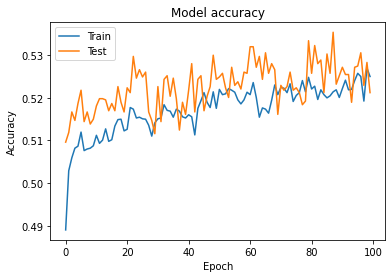

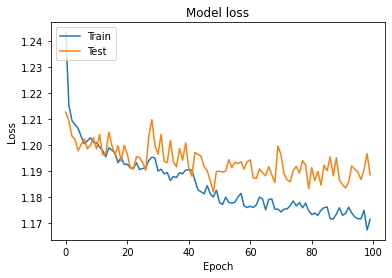

In [0]:
plot_train_val(history2)

In [0]:
y_pred = [np.argmax(y) for y in model2.predict(x_test)]
print(classification_report(y_test, y_pred))
# y_pred = [np.where(y == 1)[0][0] for y in y_pred]
print('cohen kappa score:', cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.15      0.23       826
           1       0.00      0.00      0.00       509
           2       0.17      0.00      0.00       437
           3       0.52      0.96      0.67      1766

    accuracy                           0.52      3538
   macro avg       0.29      0.28      0.23      3538
weighted avg       0.39      0.52      0.39      3538

cohen kappa score: 0.07101771990311934


# FE3

In [0]:
import pickle
train = pickle.load(open('/content/drive/My Drive/introml/fe/fe3/fe3_train.pkl', 'rb'))
test = pickle.load(open('/content/drive/My Drive/introml/fe/fe3/fe3_test.pkl', 'rb'))

## Data Preprocessing

In [0]:
columns_w_timestamp = ['last_assessment_timestamp', 'last_game_timestamp','last_activity_timestamp']
train = train.drop(columns_w_timestamp, axis=1)
train = train.fillna(0)

# test = test.drop(columns_w_timestamp, axis=1)
# test = test.fillna(0)
x_all = train.drop(columns='accuracy_group')
y_all = train['accuracy_group']

x_train, x_test,y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

In [0]:
num_features = x_test.shape[1]
num_classes = len(set(y_test))
print(num_features, "features")
print(num_classes, "classes")

513 features
4 classes


In [0]:
model3 = build_model(num_features, num_classes)
checkpoints = ModelCheckpoint("/content/drive/My Drive/introml/model/nn/checkpoints/fe3-weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 513)               263682    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32896     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 298,790
Trainable params: 298,790
Non-trainable params: 0
_________________________________________________________________


In [0]:
history3 = model3.fit(np.array(x_train), np.array(y_train_cat), validation_split=0.25, epochs=100, batch_size=32, callbacks=[checkpoints])
# model.evaluate(x_val, y_val)

Train on 10614 samples, validate on 3538 samples
Epoch 1/100
10614/10614 [==============================] - 3s 241us/sample - loss: 1.2313 - accuracy: 0.4977 - val_loss: 1.2080 - val_accuracy: 0.5164
Epoch 2/100
10614/10614 [==============================] - 2s 172us/sample - loss: 1.2204 - accuracy: 0.5028 - val_loss: 1.2061 - val_accuracy: 0.5170
Epoch 3/100
10614/10614 [==============================] - 2s 180us/sample - loss: 1.2178 - accuracy: 0.5026 - val_loss: 1.2061 - val_accuracy: 0.5150
Epoch 4/100
10614/10614 [==============================] - 2s 168us/sample - loss: 1.2166 - accuracy: 0.5041 - val_loss: 1.2037 - val_accuracy: 0.5181
Epoch 5/100
10614/10614 [==============================] - 2s 152us/sample - loss: 1.2151 - accuracy: 0.5046 - val_loss: 1.2173 - val_accuracy: 0.5155
Epoch 6/100
10614/10614 [==============================] - 2s 145us/sample - loss: 1.2167 - accuracy: 0.5037 - val_loss: 1.2048 - val_accuracy: 0.5144
Epoch 7/100
10614/10614 [====================

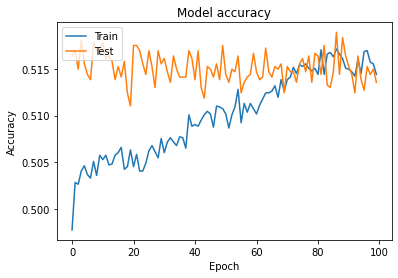

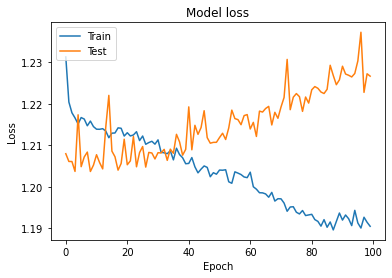

In [0]:
plot_train_val(history3)

In [0]:
y_pred = [np.argmax(y) for y in model3.predict(x_test)]
print(classification_report(y_test, y_pred))
# y_pred = [np.where(y == 1)[0][0] for y in y_pred]
print('cohen kappa score:', cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.06      0.10       858
           1       0.00      0.00      0.00       490
           2       0.33      0.01      0.02       443
           3       0.50      0.97      0.66      1747

    accuracy                           0.50      3538
   macro avg       0.31      0.26      0.19      3538
weighted avg       0.39      0.50      0.35      3538

cohen kappa score: 0.024682876398237075


## Remove Correlated Features

In [0]:
def remove_correlated_features(reduce_train, features):
    counter = 0
    to_remove = []
    for feat_a in features:
        for feat_b in features:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
                if c > 0.9999:
                    counter += 1
                    to_remove.append(feat_b)
                    print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    return to_remove

In [0]:
feat_labels = list(train.columns)
remove_list = remove_correlated_features(train, feat_labels )

1: FEAT_A: b2dba42b FEAT_B: 1bb5fbdb - Correlation: 0.9999405639639954
2: FEAT_A: dcaede90 FEAT_B: 2040 - Correlation: 1.0
3: FEAT_A: f71c4741 FEAT_B: f7e47413 - Correlation: 0.9999464999851319
4: FEAT_A: 2b9272f4 FEAT_B: 37c53127 - Correlation: 0.9999777600181912
5: FEAT_A: 2b9272f4 FEAT_B: 2050 - Correlation: 0.9999777600181912
6: FEAT_A: d88e8f25 FEAT_B: ac92046e - Correlation: 0.9999716958360618
7: FEAT_A: c277e121 FEAT_B: b120f2ac - Correlation: 0.9999845666155784
8: FEAT_A: 3bfd1a65 FEAT_B: db02c830 - Correlation: 0.9999982079383459
9: FEAT_A: 9d29771f FEAT_B: c74f40cd - Correlation: 0.9999444921075749
10: FEAT_A: 83c6c409 FEAT_B: 3dfd4aa4 - Correlation: 0.9999827146479853
11: FEAT_A: f28c589a FEAT_B: a1bbe385 - Correlation: 0.9999559134451931
12: FEAT_A: 5154fc30 FEAT_B: 3babcb9b - Correlation: 0.9999824088485433
13: FEAT_A: 0a08139c FEAT_B: 71fe8f75 - Correlation: 0.9999762369223734
14: FEAT_A: a6d66e51 FEAT_B: 5000 - Correlation: 0.9999999999999998
15: FEAT_A: 71e712d8 FEAT_B:

In [0]:
train_remove_corr = train.drop(remove_list, axis=1)
test_remove_corr = test.drop(remove_list, axis=1)

x_all = train_remove_corr.drop(columns='accuracy_group')
y_all = train_remove_corr['accuracy_group']

x_train, x_test,y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

In [0]:
feat_labels = train_remove_corr.columns

In [0]:
train_remove_corr.head()

,Clip,Activity,Assessment,Game,session_title,Magma Peak - Level 1,Sandcastle Builder (Activity),Slop Problem,Scrub-A-Dub,Tree Top City - Level 1,Ordering Spheres,All Star Sorting,Costume Box,Fireworks (Activity),12 Monkeys,Tree Top City - Level 2,Flower Waterer (Activity),Pirate's Tale,Mushroom Sorter (Assessment),Air Show,Treasure Map,Tree Top City - Level 3,Crystals Rule,Rulers,Bug Measurer (Activity),Bird Measurer (Assessment),Watering Hole (Activity),Magma Peak - Level 2,Dino Drink,Bubble Bath,Bottle Filler (Activity),Dino Dive,Crystal Caves - Level 1,Chow Time,Cauldron Filler (Assessment),Balancing Act,Crystal Caves - Level 2,Crystal Caves - Level 3,Chicken Balancer (Activity),Lifting Heavy Things,...,2070,4110,4045,4095,2075,4080,MAGMAPEAK,TREETOPCITY,CRYSTALCAVES,Cauldron Filler (Assessment)_4020_accuracy,Bird Measurer (Assessment)_4020_accuracy,Chest Sorter (Assessment)_4020_accuracy,correct_Mushroom Sorter (Assessment),wrong_Bird Measurer (Assessment),correct_Cart Balancer (Assessment),wrong_Cart Balancer (Assessment),correct_Chest Sorter (Assessment),correct_Cauldron Filler (Assessment),wrong_Cauldron Filler (Assessment),game_session,total_game_misses,mean_game_round,installation_id,last_activity_session_title,last_activity_world,last_activity_event_count,last_game_session_title,last_game_world,last_game_event_count,activity_durations_mean,game_durations_mean,assessment_durations_mean,Game_gametime,Activity_gametime,Assessment_gametime,accuracy_group,last_assessment_session_title,last_assessment_world,last_assessment_event_count,last_assessment_accuracy_group
0,8,6,1,8,13,2,102,2,361,1,1,125,2,299,2,0,166,2,35,0,1,0,0,0,204,0,59,0,105,133,183,15,0,0,0,0,0,0,0,0,...,0,0,2,1,1,0,962,838,0,0.0,0.0,0.0,1,0,0,0,0,0,0,190857,15,9.292969,2546,25.0,0.0,182.0,3.0,0.0,166.0,342.571429,135.375000,0.000000,1083,2398,0,3,0.0,0.0,0.0,0.0
1,9,6,2,9,20,2,102,2,361,1,1,153,2,299,2,0,166,2,35,0,2,0,150,0,204,87,59,0,105,133,183,15,0,0,0,0,0,0,0,0,...,0,11,2,1,1,0,962,1104,0,0.0,0.0,0.0,1,11,0,0,0,0,0,142454,17,4.823242,2546,25.0,0.0,182.0,6.0,1.0,28.0,342.571429,134.500000,26.000000,1345,2398,26,0,13.0,1.0,35.0,3.0
2,12,7,3,12,13,3,102,2,361,1,1,153,3,299,2,1,166,2,83,295,2,0,151,0,204,87,59,1,105,133,293,64,0,0,0,0,0,0,0,0,...,1,13,2,1,2,0,1123,1450,0,0.0,0.0,0.0,2,11,0,0,0,0,0,13764,17,1.176453,2546,25.0,0.0,110.0,26.0,0.0,49.0,320.375000,123.857143,59.000000,1734,2563,118,3,20.0,1.0,87.0,0.0
3,12,7,3,12,13,3,102,2,361,1,1,153,3,299,2,1,166,2,125,295,2,0,151,0,204,87,59,1,105,133,293,64,0,0,0,0,0,0,0,0,...,1,13,2,1,2,0,1123,1492,0,0.0,0.0,0.0,3,11,0,0,0,0,0,10506,17,1.176453,2546,25.0,0.0,110.0,26.0,0.0,49.0,320.375000,123.857143,52.333333,1734,2563,157,2,13.0,1.0,48.0,3.0
4,13,9,4,12,20,3,161,3,361,1,1,153,3,299,2,1,166,2,125,295,2,0,151,1,319,119,97,1,105,133,293,64,0,0,0,0,0,0,0,0,...,1,14,2,1,2,0,1221,1640,0,0.0,0.5,0.0,3,11,0,0,0,0,0,57030,17,1.176453,2546,1.0,0.0,59.0,26.0,0.0,49.0,248.727273,123.857143,47.000000,1734,2736,188,3,13.0,1.0,42.0,2.0


In [0]:
num_features = x_test.shape[1]
num_classes = len(set(y_test))
print(num_features, "features")
print(num_classes, "classes")

474 features
4 classes


In [0]:
model3a = build_model(num_features, num_classes)
checkpoints = ModelCheckpoint("/content/drive/My Drive/introml/model/nn/checkpoints/fe3-corr-weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 474)               225150    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                30400     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 132       
Total params: 257,762
Trainable params: 257,762
Non-trainable params: 0
_________________________________________________________________


In [0]:
history3a = model3a.fit(np.array(x_train), np.array(y_train_cat), validation_split=0.25, epochs=100, batch_size=32, callbacks=[checkpoints])
# model.evaluate(x_val, y_val)

Train on 10614 samples, validate on 3538 samples
Epoch 1/100
10614/10614 [==============================] - 3s 254us/sample - loss: 1.2302 - accuracy: 0.4977 - val_loss: 1.2122 - val_accuracy: 0.5158
Epoch 2/100
10614/10614 [==============================] - 2s 170us/sample - loss: 1.2208 - accuracy: 0.5036 - val_loss: 1.2051 - val_accuracy: 0.5155
Epoch 3/100
10614/10614 [==============================] - 2s 167us/sample - loss: 1.2183 - accuracy: 0.5048 - val_loss: 1.2043 - val_accuracy: 0.5164
Epoch 4/100
10614/10614 [==============================] - 2s 159us/sample - loss: 1.2172 - accuracy: 0.5052 - val_loss: 1.2055 - val_accuracy: 0.5150
Epoch 5/100
10614/10614 [==============================] - 2s 147us/sample - loss: 1.2173 - accuracy: 0.5050 - val_loss: 1.2058 - val_accuracy: 0.5167
Epoch 6/100
10614/10614 [==============================] - 2s 151us/sample - loss: 1.2167 - accuracy: 0.5056 - val_loss: 1.2065 - val_accuracy: 0.5172
Epoch 7/100
10614/10614 [====================

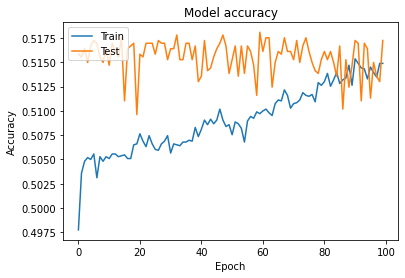

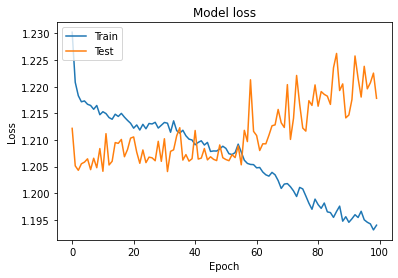

In [0]:
plot_train_val(history3a)

In [0]:
y_pred = [np.argmax(y) for y in model3a.predict(x_test)]
print(classification_report(y_test, y_pred))
# y_pred = [np.where(y == 1)[0][0] for y in y_pred]
print('cohen kappa score:', cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.03      0.06       858
           1       0.14      0.00      0.00       490
           2       0.18      0.00      0.01       443
           3       0.50      0.99      0.66      1747

    accuracy                           0.50      3538
   macro avg       0.32      0.26      0.18      3538
weighted avg       0.40      0.50      0.34      3538

cohen kappa score: 0.015782041477749087


## Feature Selection

In [0]:
# From RFE
selected_features = ['Clip',
 'Assessment',
 'session_title',
 'Mushroom Sorter (Assessment)',
 'Bird Measurer (Assessment)',
 'Cauldron Filler (Assessment)',
 'Cart Balancer (Assessment)',
 'Chest Sorter (Assessment)',
 0,
 1,
 2,
 3,
 '3bfd1a65',
 'a52b92d5',
 '9d29771f',
 '7da34a02',
 '83c6c409',
 'fbaf3456',
 '5f0eb72c',
 'c7128948',
 '25fa8af4',
 '6c930e6e',
 'a5be6304',
 'ec138c1c',
 '1375ccb7',
 'bdf49a58',
 '51102b85',
 '4a4c3d21',
 '17113b36',
 'ad2fc29c',
 'e37a2b78',
 'a16a373e',
 '160654fd',
 '88d4a5be',
 '45d01abe',
 '7525289a',
 'f6947f54',
 '8fee50e2',
 '070a5291',
 '3393b68b',
 '532a2afb',
 '923afab1',
 '3ee399c3',
 '37ee8496',
 '30614231',
 '2dcad279',
 '392e14df',
 '28520915',
 'd3268efa',
 'b5053438',
 '7ad3efc6',
 '795e4a37',
 '5e109ec3',
 '5c2f29ca',
 '828e68f9',
 'd122731b',
 'a8876db3',
 'ecaab346',
 'b2e5b0f1',
 '5b49460a',
 '3dcdda7f',
 '3ccd3f02',
 'bd612267',
 'a8efe47b',
 '562cec5f',
 '0db6d71d',
 '9ce586dd',
 '93b353f2',
 'ea296733',
 'df4fe8b6',
 'acf5c23f',
 '91561152',
 '2b058fe3',
 '5de79a6a',
 '31973d56',
 '04df9b66',
 '5290eab1',
 '3afb49e6',
 'e4f1efe6',
 '38074c54',
 2000,
 4030,
 4020,
 2030,
 3021,
 3020,
 3120,
 4025,
 4100,
 2010,
 4110,
 'Cauldron Filler (Assessment)_4020_accuracy',
 'Bird Measurer (Assessment)_4020_accuracy',
 'correct_Mushroom Sorter (Assessment)',
 'wrong_Bird Measurer (Assessment)',
 'correct_Cart Balancer (Assessment)',
 'wrong_Cart Balancer (Assessment)',
 'correct_Chest Sorter (Assessment)',
 'correct_Cauldron Filler (Assessment)',
 'wrong_Cauldron Filler (Assessment)',
 'assessment_durations_mean',
 'Assessment_gametime',
 'accuracy_group',
 'last_assessment_world',
 'last_assessment_event_count']

In [0]:
filtered_train = train_remove_corr[selected_features]
filtered_test = test_remove_corr[selected_features]
feature_labels = filtered_train.columns

In [0]:
filtered_test.head()

,Clip,Assessment,session_title,Mushroom Sorter (Assessment),Bird Measurer (Assessment),Cauldron Filler (Assessment),Cart Balancer (Assessment),Chest Sorter (Assessment),0,1,2,3,3bfd1a65,a52b92d5,9d29771f,7da34a02,83c6c409,fbaf3456,5f0eb72c,c7128948,25fa8af4,6c930e6e,a5be6304,ec138c1c,1375ccb7,bdf49a58,51102b85,4a4c3d21,17113b36,ad2fc29c,e37a2b78,a16a373e,160654fd,88d4a5be,45d01abe,7525289a,f6947f54,8fee50e2,070a5291,3393b68b,...,0db6d71d,9ce586dd,93b353f2,ea296733,df4fe8b6,acf5c23f,91561152,2b058fe3,5de79a6a,31973d56,04df9b66,5290eab1,3afb49e6,e4f1efe6,38074c54,2000,4030,4020,2030,3021,3020,3120,4025,4100,2010,4110,Cauldron Filler (Assessment)_4020_accuracy,Bird Measurer (Assessment)_4020_accuracy,correct_Mushroom Sorter (Assessment),wrong_Bird Measurer (Assessment),correct_Cart Balancer (Assessment),wrong_Cart Balancer (Assessment),correct_Chest Sorter (Assessment),correct_Cauldron Filler (Assessment),wrong_Cauldron Filler (Assessment),assessment_durations_mean,Assessment_gametime,accuracy_group,last_assessment_world,last_assessment_event_count
0,5,2,38,0,0,1,26,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,17,107,90,3,3,1,1,10,1,1,0,0.0,0.0,0,0,1,0,0,0,0,0.0,0,3,0.0,1.0
1,14,5,38,51,61,36,14,83,2,1,2,1,1,4,4,10,1,6,5,1,2,1,1,2,4,4,14,8,3,3,3,7,1,1,1,1,2,5,2,1,...,3,1,3,3,3,0,1,1,0,0,1,1,0,0,0,49,384,304,76,66,24,24,87,23,4,3,0.0,0.0,1,2,1,0,0,1,1,46.6,233,3,2.0,83.0
2,0,1,13,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,NaN,0,0,NaN,NaN
3,2,1,13,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,61,31,3,3,2,2,9,0,0,0,0.0,0.0,0,0,0,0,0,0,0,NaN,0,0,NaN,NaN
4,1,1,38,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,NaN,0,0,NaN,NaN


In [0]:
# test_x_all = filtered_test.drop(['accuracy_group'], axis=1)
# test_y_all = filtered_test['accuracy_group']

x_all = filtered_train.drop(columns='accuracy_group')
y_all = filtered_train['accuracy_group']

x_train, x_test,y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

In [0]:
num_features = x_test.shape[1]
num_classes = len(set(y_test))
print(num_features, "features")
print(num_classes, "classes")

104 features
4 classes


In [0]:
model3b = build_model(num_features, num_classes)
checkpoints = ModelCheckpoint("/content/drive/My Drive/introml/model/nn/checkpoints/fe3-select-weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 104)               10920     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                6720      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 132       
Total params: 19,852
Trainable params: 19,852
Non-trainable params: 0
_________________________________________________________________


In [0]:
history3b = model3b.fit(np.array(x_train), np.array(y_train_cat), validation_split=0.25, epochs=100, batch_size=32, callbacks=[checkpoints])
# model.evaluate(x_val, y_val)

Train on 10614 samples, validate on 3538 samples
Epoch 1/100
10614/10614 [==============================] - 2s 197us/sample - loss: 1.1300 - accuracy: 0.5406 - val_loss: 1.0365 - val_accuracy: 0.5845
Epoch 2/100
10614/10614 [==============================] - 2s 143us/sample - loss: 0.9991 - accuracy: 0.5947 - val_loss: 0.9744 - val_accuracy: 0.6142
Epoch 3/100
10614/10614 [==============================] - 1s 139us/sample - loss: 0.9408 - accuracy: 0.6236 - val_loss: 0.9414 - val_accuracy: 0.6328
Epoch 4/100
10614/10614 [==============================] - 2s 145us/sample - loss: 0.9042 - accuracy: 0.6377 - val_loss: 0.8792 - val_accuracy: 0.6532
Epoch 5/100
10614/10614 [==============================] - 2s 143us/sample - loss: 0.8703 - accuracy: 0.6498 - val_loss: 0.8690 - val_accuracy: 0.6583
Epoch 6/100
10614/10614 [==============================] - 2s 142us/sample - loss: 0.8460 - accuracy: 0.6616 - val_loss: 0.8490 - val_accuracy: 0.6594
Epoch 7/100
10614/10614 [====================

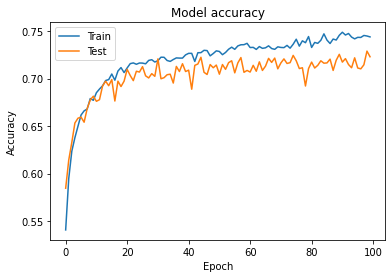

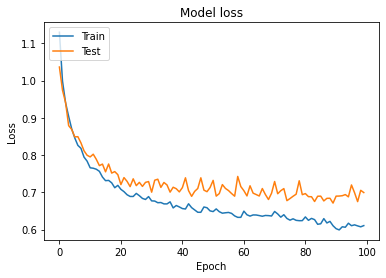

In [0]:
plot_train_val(history3b)

In [0]:
y_pred = [np.argmax(y) for y in model3b.predict(x_test)]
print(classification_report(y_test, y_pred))
# y_pred = [np.where(y == 1)[0][0] for y in y_pred]
print('cohen kappa score:', cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       858
           1       0.76      0.49      0.60       490
           2       0.70      0.42      0.53       443
           3       0.72      0.90      0.80      1747

    accuracy                           0.72      3538
   macro avg       0.72      0.61      0.65      3538
weighted avg       0.72      0.72      0.70      3538

cohen kappa score: 0.545206787242486


# Hyperparameter Tuning

In [0]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=e1a6b36d127e4201a15d195f15d48d8f54471b747c41072b45920a2d206bf18c
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=b31da201d5dbcf099cc90743b704096ec474d7085bedbfc3a9bc173502ba0256
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
!rm -rf "/content/drive/My Drive/introml/model/nn/randomsearch"

In [0]:
from kerastuner import HyperModel, RandomSearch

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Dense(num_features, activation='tanh'))
        model.add(Dense(units=hp.Int('units',
                                            min_value=32,
                                            max_value=128,
                                            step=32),
                               activation='tanh'))
        model.add(Dense(units=hp.Int('units',
                                            min_value=32,
                                            max_value=128,
                                            step=32),
                               activation='tanh'))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(
            optimizer='nadam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return model


hypermodel = MyHyperModel(num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='/content/drive/My Drive/introml/model/nn',
    project_name='randomsearch')

tuner.search(np.array(x_train), np.array(y_train),
             epochs=5,
             validation_data=(np.array(x_test), np.array(y_test)))

Train on 14152 samples, validate on 3538 samples
Epoch 1/5
14152/14152 [==============================] - 3s 199us/sample - loss: 14.2548 - accuracy: 0.9875 - val_loss: 14.0053 - val_accuracy: 1.0000
Epoch 2/5
14152/14152 [==============================] - 2s 151us/sample - loss: 14.0806 - accuracy: 0.9910 - val_loss: 13.9153 - val_accuracy: 0.9802
Epoch 3/5
14152/14152 [==============================] - 2s 150us/sample - loss: 13.9781 - accuracy: 0.9753 - val_loss: 13.9477 - val_accuracy: 0.9562
Epoch 4/5
14152/14152 [==============================] - 2s 144us/sample - loss: 13.9443 - accuracy: 0.9700 - val_loss: 13.7495 - val_accuracy: 0.9666
Epoch 5/5
14152/14152 [==============================] - 2s 144us/sample - loss: 13.8433 - accuracy: 0.9649 - val_loss: 13.6495 - val_accuracy: 0.9683


Train on 14152 samples, validate on 3538 samples
Epoch 1/5
14152/14152 [==============================] - 3s 197us/sample - loss: 12.7451 - accuracy: 0.9703 - val_loss: 12.5736 - val_accuracy: 1.0000
Epoch 2/5
14152/14152 [==============================] - 2s 152us/sample - loss: 12.6734 - accuracy: 1.0000 - val_loss: 12.4695 - val_accuracy: 1.0000
Epoch 3/5
14152/14152 [==============================] - 2s 151us/sample - loss: 12.5803 - accuracy: 1.0000 - val_loss: 12.4187 - val_accuracy: 1.0000
Epoch 4/5
14152/14152 [==============================] - 2s 145us/sample - loss: 12.5299 - accuracy: 1.0000 - val_loss: 12.3649 - val_accuracy: 1.0000
Epoch 5/5
14152/14152 [==============================] - 2s 150us/sample - loss: 12.4663 - accuracy: 1.0000 - val_loss: 12.3523 - val_accuracy: 1.0000


Train on 14152 samples, validate on 3538 samples
Epoch 1/5
14152/14152 [==============================] - 3s 200us/sample - loss: 11.0971 - accuracy: 0.0044 - val_loss: 10.9648 - val_accuracy: 0.0000e+00
Epoch 2/5
14152/14152 [==============================] - 2s 147us/sample - loss: 11.0622 - accuracy: 0.0000e+00 - val_loss: 10.9413 - val_accuracy: 0.0000e+00
Epoch 3/5
14152/14152 [==============================] - 2s 144us/sample - loss: 11.0443 - accuracy: 0.0000e+00 - val_loss: 10.9315 - val_accuracy: 0.0000e+00
Epoch 4/5
14152/14152 [==============================] - 2s 146us/sample - loss: 11.0389 - accuracy: 0.0000e+00 - val_loss: 10.9142 - val_accuracy: 0.0000e+00
Epoch 5/5
14152/14152 [==============================] - 2s 151us/sample - loss: 11.0275 - accuracy: 0.0000e+00 - val_loss: 10.8991 - val_accuracy: 0.0000e+00


Train on 14152 samples, validate on 3538 samples
Epoch 1/5
14152/14152 [==============================] - 3s 197us/sample - loss: 11.7497 - accuracy: 0.0098 - val_loss: 11.5561 - val_accuracy: 0.0000e+00
Epoch 2/5
14152/14152 [==============================] - 2s 161us/sample - loss: 11.6606 - accuracy: 7.0661e-05 - val_loss: 11.5313 - val_accuracy: 5.6529e-04
Epoch 3/5
14152/14152 [==============================] - 2s 151us/sample - loss: 11.6283 - accuracy: 0.0020 - val_loss: 11.4934 - val_accuracy: 5.6529e-04
Epoch 4/5
14152/14152 [==============================] - 2s 155us/sample - loss: 11.6001 - accuracy: 0.0023 - val_loss: 11.5047 - val_accuracy: 0.0023
Epoch 5/5
14152/14152 [==============================] - 2s 157us/sample - loss: 11.5957 - accuracy: 0.0073 - val_loss: 11.4551 - val_accuracy: 0.0144


INFO:tensorflow:Oracle triggered exit


In [0]:
best_model = tuner.get_best_models(num_models=1)[0]

In [0]:
checkpoints = ModelCheckpoint("/content/drive/My Drive/introml/model/nn/checkpoints/fe3-best-weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [0]:
history = best_model.fit(np.array(x_train), np.array(y_train_cat), validation_split=0.25, epochs=100, batch_size=32, callbacks=[checkpoints])

Train on 10614 samples, validate on 3538 samples
Epoch 1/100
10614/10614 [==============================] - 3s 243us/sample - loss: 1.2660 - accuracy: 0.4634 - val_loss: 1.2082 - val_accuracy: 0.5119
Epoch 2/100
10614/10614 [==============================] - 2s 152us/sample - loss: 1.2221 - accuracy: 0.4983 - val_loss: 1.2093 - val_accuracy: 0.5122
Epoch 3/100
10614/10614 [==============================] - 2s 175us/sample - loss: 1.2216 - accuracy: 0.4990 - val_loss: 1.2043 - val_accuracy: 0.5164
Epoch 4/100
10614/10614 [==============================] - 2s 159us/sample - loss: 1.1917 - accuracy: 0.5220 - val_loss: 1.1239 - val_accuracy: 0.5692
Epoch 5/100
10614/10614 [==============================] - 2s 158us/sample - loss: 1.0921 - accuracy: 0.5715 - val_loss: 1.0297 - val_accuracy: 0.5955
Epoch 6/100
10614/10614 [==============================] - 2s 159us/sample - loss: 1.0187 - accuracy: 0.5969 - val_loss: 0.9727 - val_accuracy: 0.6176
Epoch 7/100
10614/10614 [====================

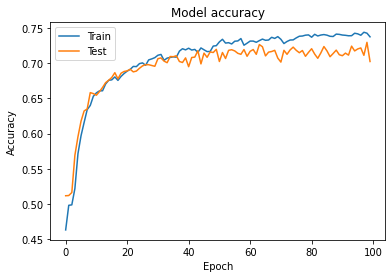

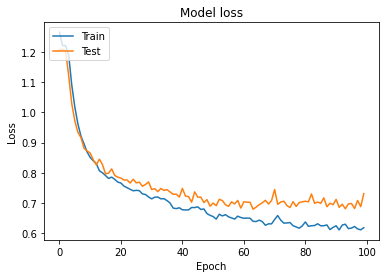

In [0]:
plot_train_val(history)

In [0]:
y_pred = [np.argmax(y) for y in model3b.predict(x_test)]
print(classification_report(y_test, y_pred))
# y_pred = [np.where(y == 1)[0][0] for y in y_pred]
print('cohen kappa score:', cohen_kappa_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       858
           1       0.76      0.49      0.60       490
           2       0.70      0.42      0.53       443
           3       0.72      0.90      0.80      1747

    accuracy                           0.72      3538
   macro avg       0.72      0.61      0.65      3538
weighted avg       0.72      0.72      0.70      3538

cohen kappa score: 0.545206787242486
